# Data Cleaning

# Intro

The goal of this project is to perform unsupervised learning techniques on song lyric (*text*) data in order to find topics in songs that may be useful in tagging lyrics for their content. The dataset, [380,000+ lyrics from MetroLyrics](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data), is from Kaggle and contains over 380,000 song lyrics as well as some useful tags for the songs as well.

Steps for this notebook are:
1. **Load in data** - from .csv using Pandas
2. **Clean the data** - using various methods
3. **Export data as deliverables** - for later use (without having to clean for every notebook)

Deliverables:
1. **Corpus** - pickle file
2. **Document Term Matrix** - pickle file

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer

pd.options.display.max_colwidth = 100

Use tqdm package just for spacy pandas apply.

In [2]:
%%capture
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

## Loading data then taking a sample

A few things will be done in this step:
1. Load in data with pandas into a data frame
2. Limit the scope of the data
3. Pre-textprocessing preprocessing
4. Generate Random Sample (and pickle)

### Load data

In [3]:
orig_df = pd.read_csv(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\source\lyrics.csv').iloc[:, 1:]

### Limiting scope

Not including songs from before 2010. No particular reason, just cutting it off there.

In [4]:
df = orig_df[orig_df.year >= 2010].copy()

Drop songs with "Other" and "Not Available" genres (for exploration and explainability).

In [5]:
df = df[(df.genre != 'Other') & (df.genre != 'Not Available')].copy()

### Pre-textprocessing preprocessing

Drop null lyrics - no use for those...

In [6]:
df = df[~df.lyrics.isna()].copy()

Drop instrumental tracks (we could tag these relatively easily with a simple rule). I.e. if the character length of lyrics is below a certain threshold and instrumental is the only word in the lyrics.

In [7]:
instrumental_drops = ['INSTRUMENTAL', '(instrumental)', 'Instrumental', '(Instrumental)', '- instrumental -', '[Instrumental]']
df['lyrics'] = df.lyrics.apply(lambda x: np.nan if x in instrumental_drops else x)
df = df.dropna().copy()

Get rid of remixes, studio versions and covers. 

In [8]:
df = df[~df.song.str.contains('remix')].copy()
df = df[~df.song.str.contains('studio')].copy()
df = df[~df.song.str.contains('-cover')].copy()

Random shuffle before eliminating duplicate lyrics (songs with identical lyrics).

In [9]:
df = df.sample(frac=1, random_state=27).copy() #random shuffle
df = df[~df.lyrics.duplicated()]#eliminate duplicates, keeping first instance of lyric

Get rid of all songs 2 standard deviations higher than the Hip-Hop average (it has the greatest average of any genre and greatest standard deviation, I don't want to eliminate too many Hip-Hop songs just because they are generally longer than other genres).

In [10]:
df['song_len'] = df.lyrics.str.len()
hip_hop_2std = df.groupby('genre').std().song_len['Hip-Hop']*2 #2 standard deviations for Hip-Hop genre song length
hip_hop_avg = df.groupby('genre').mean().song_len['Hip-Hop'] #average character length for Hip-Hop song
max_len = hip_hop_2std + hip_hop_avg
max_len

4704.19510580339

In [11]:
df = df[df.song_len < max_len].copy()

So that takes care of most of the long songs (there are none left considering Hip-Hop alone). Looking at songs with very short character values is also pretty useless (lots of them are misspelling of instrumental or 'add lyrics') so those can be removed.

In [12]:
df = df[df.song_len > 100].copy()

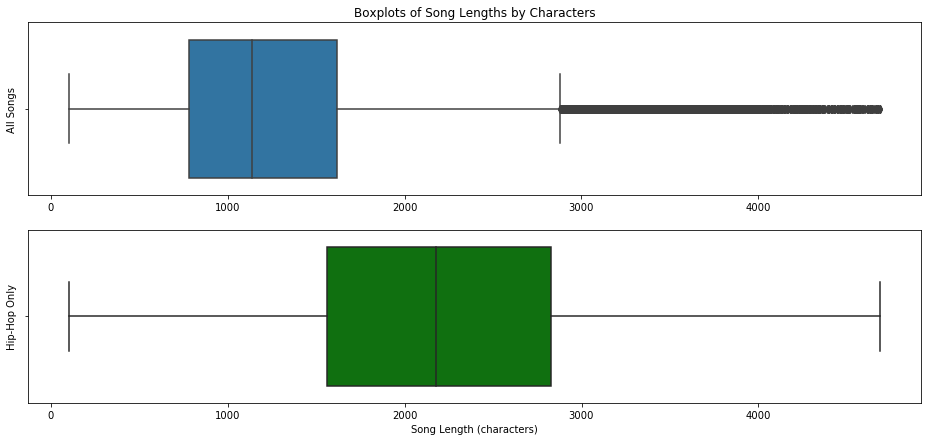

In [13]:
plt.figure(figsize=(16, 7))

plt.subplot(211)
sns.boxplot(df.song_len)
plt.title('Boxplots of Song Lengths by Characters')
plt.xlabel('')
plt.ylabel('All Songs')

plt.subplot(212)
sns.boxplot(df[df.genre == 'Hip-Hop'].song_len, color='g')
plt.xlabel('Song Length (characters)')
plt.ylabel('Hip-Hop Only')
plt.show()

Next, get rid of all songs that aren't in English. The detect function from langdetect is very useful and relatively fast for this process.

In [14]:
def try_detect(x):
    try:
        return detect(x) #returns 2 digit language code
    except:
        return None #if error don't assign a language

In [15]:
df['language'] = df.lyrics.progress_apply(try_detect)

100%|███████████████████████████████████████| 57165/57165 [21:41<00:00, 43.92it/s]


Keep only songs that are English ("en").

In [16]:
df = df[df.language == 'en'].copy()

### Generate random sample (and compare to original population)

Take a random sample of 10000 songs.

In [17]:
samp_df = df.sample(n=10000, random_state=27).copy()

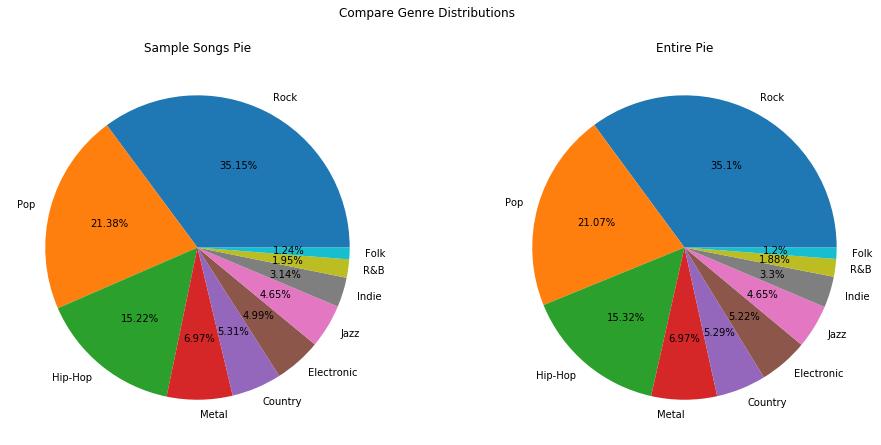

In [18]:
plt.figure(figsize=(16, 7))

plt.suptitle('Compare Genre Distributions')

plt.subplot(121)
plt.pie(samp_df.genre.value_counts(True), labels=samp_df.genre.value_counts(True).index, autopct=lambda x: f'{round(x, 2)}%')
plt.title('Sample Songs Pie')

plt.subplot(122)
plt.pie(df.genre.value_counts(True), labels=samp_df.genre.value_counts(True).index, autopct=lambda x: f'{round(x, 2)}%')
plt.title('Entire Pie')

plt.show()

Breakdown of the sample from the total population (by genre) appears to be even.

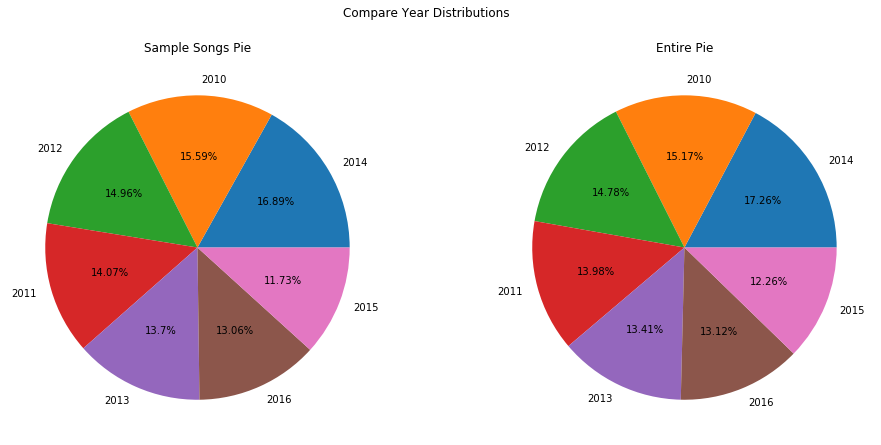

In [19]:
plt.figure(figsize=(16, 7))

plt.suptitle('Compare Year Distributions')

plt.subplot(121)
plt.pie(samp_df.year.value_counts(True), labels=samp_df.year.value_counts(True).index, autopct=lambda x: f'{round(x, 2)}%')
plt.title('Sample Songs Pie')

plt.subplot(122)
plt.pie(df.year.value_counts(True), labels=samp_df.year.value_counts(True).index, autopct=lambda x: f'{round(x, 2)}%')
plt.title('Entire Pie')

plt.show()

Looks pretty even on the year distribution as well.

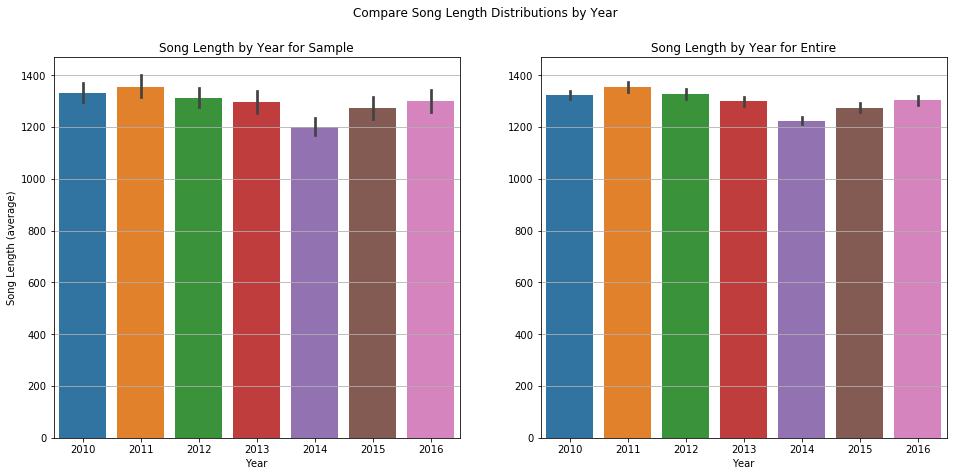

In [20]:
plt.figure(figsize=(16, 7))

plt.suptitle('Compare Song Length Distributions by Year')

plt.subplot(121)
sns.barplot(x=samp_df.year, y=samp_df.song_len)
plt.xlabel('Year')
plt.ylabel('Song Length (average)')
plt.grid(axis='y')
lim = plt.ylim()
plt.title('Song Length by Year for Sample')

plt.subplot(122)
sns.barplot(x=df.year, y=df.song_len)
plt.xlabel('Year')
plt.ylabel('')
plt.grid(axis='y')
plt.ylim(lim)
plt.title('Song Length by Year for Entire')

plt.show()

Pretty consistent, a little more volatile for sample (indicated by black bars on top of bars), but nearly the same.

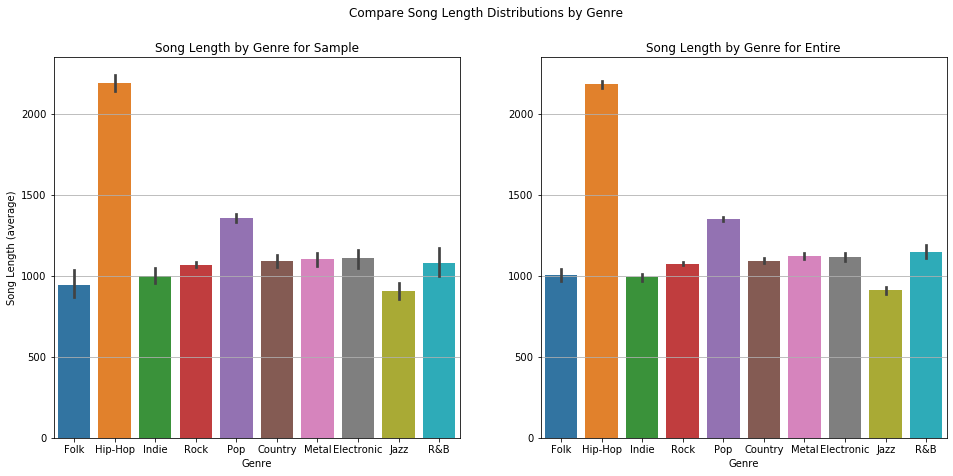

In [21]:
order = samp_df.genre.unique().tolist()

plt.figure(figsize=(16, 7))

plt.suptitle('Compare Song Length Distributions by Genre')

plt.subplot(121)
sns.barplot(x=samp_df.genre, y=samp_df.song_len, order=order)
plt.xlabel('Genre')
plt.ylabel('Song Length (average)')
plt.grid(axis='y')
lim = plt.ylim()
plt.title('Song Length by Genre for Sample')

plt.subplot(122)
sns.barplot(x=df.genre, y=df.song_len, order=order)
plt.xlabel('Genre')
plt.ylabel('')
plt.grid(axis='y')
plt.ylim(lim)
plt.title('Song Length by Genre for Entire')

plt.show()

Again, almost identical, R&B for the sample is a little greater on average and Folk is a little less than average, but not by a significant margin.

With confidence in the sample, put it in a pickle for later use, before any text manipulation.

In [22]:
samp_df.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\base_no_clean_sample.pkl')

In [23]:
samp_df = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\base_no_clean_sample.pkl')

## Cleaning text

The key here is to start simple!
- Convert to lower case
- Get rid of whitespace
- Get rid of (most) punctuation
- Get rid of numbers
- Get rid of stop words

### Round 1

Create a generator to iterate through and inspect songs individually. (Useful for detecting potentially problematic strings or characters.) This will be used between iterations.

In [24]:
def iter_songs(i, data):
    '''A generator for a series of text to easily view song by song in scratchpad starting at a particular (iloc) location.'''
    while True:
        yield print('-----Song #' + str(i) + '-----' + '\n' + data.iloc[i])
        i += 1

In [25]:
simp_gen = iter_songs(0, samp_df.lyrics)

Do first run of text cleaning. 

Really basic stuff here:
1. **Lowercase** all characters
2. Remove **whitespace**

That's it!

In [26]:
def simple_clean(text):
    '''Converts characters to lowercase, removes whitespace (split/join and strip)'''
    text = text.lower()
    text = ' '.join(text.split())
    text = text.strip()
    return text

In [27]:
samp_df['clean1'] = samp_df.lyrics.apply(simple_clean)

In [28]:
samp_df.clean1.head()

130667    fluffle-o towel wrapped around your head fluffle-o stretched right across my bed fluffle-o, fluf...
17978     i'm like hey, wassup, hello seen yo pretty ass soon as you came in the door i just wanna chill, ...
53137     sunlight is not enough we could burn like a flame through the atmosphere yeah starlight, it's ca...
64681     take my eyes burn down the sun how can you be so cold? you left me here all hope is gone where i...
28237     everything is so good in the summer air just put behind you all the problems that we share look ...
Name: clean1, dtype: object

### Round 2

Do another run of text cleaning starting with the result of the last clean (it is an iterative process).

Things of note:
1. **Repetition indication and non-lyric descriptive strings** like '[Chorus]', '[Verse]' and '[Artist]' or other non lyrical data are included in many of the lyrics - best to remove text contained and including brackets, where most of this is found
2. Get rid of (most) **punctuation**, cause most of it won't be useful

In [29]:
def remove_special_strings(text):
    '''Removes text within brackets, text leading to a ':' (usually indicates part of song in some fashion) and various punctuation.'''
    text = re.sub('\[[^\]]*\]', ' ', text) #removes strings starting with '[' and ending with ']' replace with space
    text = re.sub('[(),.?!\-"*;/~]+', ' ', text) #removes lots of punctuation replace with space
    text = re.sub('\w*:\w*', ' ', text) #removes ':' and all alphanumeric characters leading into ':' or directly following ':'
    text = text.strip()
    text = ' '.join(text.split())
    return text

In [30]:
samp_df['clean2'] = samp_df.clean1.apply(remove_special_strings)

In [31]:
samp_df.clean2.head()

130667    fluffle o towel wrapped around your head fluffle o stretched right across my bed fluffle o fluff...
17978     i'm like hey wassup hello seen yo pretty ass soon as you came in the door i just wanna chill got...
53137     sunlight is not enough we could burn like a flame through the atmosphere yeah starlight it's cal...
64681     take my eyes burn down the sun how can you be so cold you left me here all hope is gone where is...
28237     everything is so good in the summer air just put behind you all the problems that we share look ...
Name: clean2, dtype: object

In [32]:
clean2_gen = iter_songs(0, samp_df.clean2)

### Round 3

For this round:
1. The **ampersand** (**&**) character should be dealt with, and here it is generally used as an indication of the word 'and', so it should be replaced with that.
2. Words ending with **single quotes** (**'**) as in, *sleepin'*, should be dealt with and converted to their correct form (e.g. sleepin' --> sleeping)
3. Dealing with various **other cases of single quote** occurrences not including single quotes within words (e.g. **NOT** *i'm, it's, he's*)

In [33]:
def remove_special_strings2(text):
    '''Replaces "&" with "and"; fixes words ending with "in\'" with "ing"; and removes single quote from words ending with a single quote.'''
    text = re.sub('&', ' and ', text) #replaces any ampersands with the word and with spaces around (to be split later)
    text = text + ' ' #add space to the end of the string so next replace works even if last word
    text = re.sub("(in')\s", 'ing ', text) #replaces all instances of words ending in "in'" with "ing"
    text = re.sub("'+\s", ' ', text) #replaces all remaining text ending with a single quote with a space
    text = re.sub("'{2,}", ' ', text) #replaces any instances of single quotes that have 2 in a row or more
    text = text.strip()
    text = ' '.join(text.split())
    return text

In [34]:
samp_df['clean3'] = samp_df.clean2.apply(remove_special_strings2)

In [35]:
samp_df.clean3.head()

130667    fluffle o towel wrapped around your head fluffle o stretched right across my bed fluffle o fluff...
17978     i'm like hey wassup hello seen yo pretty ass soon as you came in the door i just wanna chill got...
53137     sunlight is not enough we could burn like a flame through the atmosphere yeah starlight it's cal...
64681     take my eyes burn down the sun how can you be so cold you left me here all hope is gone where is...
28237     everything is so good in the summer air just put behind you all the problems that we share look ...
Name: clean3, dtype: object

### Round 4

Remove numbers and words containing numbers from the prior iteration.

In [36]:
def remove_numbers(text):
    '''Remove numbers and words containing numbers from a string.'''
    text = re.sub('\w*\d\w*', ' ', text) #remove numbers and words with numbers
    text = text.strip()
    text = ' '.join(text.split())
    return text

In [37]:
samp_df['clean4'] = samp_df.clean3.apply(remove_numbers)

In [38]:
samp_df.clean4.head()

130667    fluffle o towel wrapped around your head fluffle o stretched right across my bed fluffle o fluff...
17978     i'm like hey wassup hello seen yo pretty ass soon as you came in the door i just wanna chill got...
53137     sunlight is not enough we could burn like a flame through the atmosphere yeah starlight it's cal...
64681     take my eyes burn down the sun how can you be so cold you left me here all hope is gone where is...
28237     everything is so good in the summer air just put behind you all the problems that we share look ...
Name: clean4, dtype: object

In [39]:
clean4_gen = iter_songs(0, samp_df.clean4)

Things are looking good, definitely more that can be done, but this is a good baseline for beginning to explore the data here.

In [40]:
clean_lyrics = samp_df.clean4

## Exporting data (deliverables)

### The Corpus (collection of texts)

This is relatively easy because it was basically already done from the start, the specific corpus is from the samp_df before the cleaning was done, so that can be exported directly.

In [41]:
corpus_df = samp_df.loc[:, 'song':'language']
corpus_df.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\corpus.pkl')

### Document Term Matrix

Easy to do with Scikit-learn's CountVectorizer!

In [42]:
stop_words = stopwords.words('english')
countvectorizer = CountVectorizer(stop_words=stop_words)

In [43]:
cv_data = countvectorizer.fit_transform(clean_lyrics)

In [44]:
dtm_data = pd.DataFrame(cv_data.toarray(), index=clean_lyrics.index, columns=countvectorizer.get_feature_names())

Pickle the Document Term Matrix (dtm_data), the countvectorizer, and the clean_lyrics.

In [50]:
clean_lyrics.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\clean_lyrics.pkl')
pickle.dump(countvectorizer, open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\countvectorizer.pkl', 'wb'))

In [51]:
dtm_data.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\doc_term_matrix.pkl')